#**Stock Price Prediction with LSTM**#

In this project, we developed a machine learning model to predict stock prices based on historical data using a Long Short-Term Memory (LSTM) neural network. The dataset consists of closing prices for multiple stocks, and the main steps involved in the project were:

1. **Data Preprocessing**: We scaled the stock prices using MinMax scaling to normalize the data, ensuring that the model could learn efficiently. We then created sequences of 60 past prices (the `seq_length`) to predict the future stock price.

2. **Model Architecture**: We built an LSTM-based neural network with four LSTM layers. These layers capture the temporal dependencies in stock price movements. A final Dense layer was used to output the predicted price.

3. **Training**: The model was trained using the past stock prices as input (`x_train`) and the next price as the target (`y_train`). We used the Adam optimizer and mean squared error as the loss function, training the model for 50 epochs.

4. **Prediction and Evaluation**: After training, the model's predictions were compared with the actual stock prices. The performance of the model was visualized by plotting the predicted prices against the actual prices.

This project demonstrated how LSTMs, which excel at handling sequential data, can be applied to time series forecasting for stock prices.


### Importing Libraries

In [2]:
import yfinance as yf
import pandas as pd

### Importing the data
Using the yfinance library to import NSE data

In [3]:
data = yf.download(['TCS.NS'], start='2021-01-01', end='2023-12-31')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,2880.000000,2940.000000,2879.000000,2928.250000,2732.786621,2681440
2021-01-04,2950.000000,3050.750000,2940.949951,3039.449951,2836.563477,5113293
2021-01-05,3039.600098,3114.250000,3039.600098,3093.000000,2886.539307,5801309
2021-01-06,3100.000000,3113.500000,3037.199951,3051.500000,2847.809570,3726716
2021-01-07,3075.000000,3080.850098,3000.250000,3032.800049,2830.357910,3717827


In [4]:
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Setting the target variable

In [5]:
data = data["Close"]

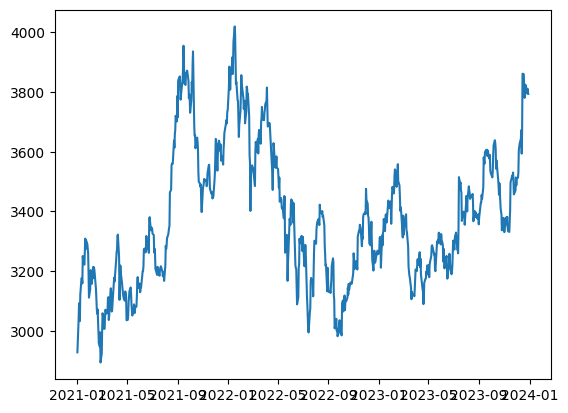

In [6]:
from matplotlib import pyplot as plt
plt.plot(data)

### Scaling the data
Neural networks, especially models like LSTM, perform better when input data is scaled. It ensures that the optimization algorithms converge faster and prevents the model from giving undue weight to larger-valued features.

We scaled the data using the MinMaxScaler, which follows the formula:

$$
X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

This ensures the values are between 0 and 1.


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

unscaled = np.array(data).reshape(-1, 1)

scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [8]:
scaled_data.shape

(741, 1)

### Train Test Split

In [9]:
train_size = int(len(scaled_data) * 0.7)
test_size = len(scaled_data) - train_size

train_data = scaled_data[:train_size,:]
test_data = scaled_data[train_size:len(scaled_data),:1]

x_train = train_data
x_test = test_data

In [10]:
test_size

223

### Sequence Creation for LSTM Model

LSTM models are designed to process sequential data and capture long-term dependencies between time steps. In the case of stock price prediction, the model needs to learn from the past stock prices to predict future prices.

We created sequences from the stock price data to achieve this. Each sequence consists of a fixed number of consecutive days' closing prices (referred to as the `seq_length`), which serve as input to the model. The stock price on the next day becomes the target value (output) for that sequence.

The process for creating sequences is as follows:
1. For each day starting from the `seq_length` day, we take the previous `seq_length` days as input (`xs`) and the price of the current day as the target (`ys`).
2. This method allows the model to learn patterns in the data by observing the relationship between past prices (input) and future prices (output).

For example, with a `seq_length` of 60:
- The input for the 61st day will be the closing prices from day 1 to day 60, and the target will be the closing price of day 61.
- The input for the 62nd day will be the closing prices from day 2 to day 61, and so on.

By creating these sequences, the LSTM model can learn from the time series data effectively and use this information to predict future stock prices.


In [11]:
import numpy as np

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:i+seq_length,0]
        y = data[i+seq_length,0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length (e.g., 60 days)
seq_length = 60

# Prepare training and testing data
x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)


### Understanding the LSTM Model for Stock Price Prediction

The model we used is based on Long Short-Term Memory (LSTM) layers, which are a type of recurrent neural network (RNN). LSTMs are particularly well-suited for time series data, like stock prices, because they are able to learn long-term dependencies and relationships in sequential data. Here's a breakdown of how the model works:

#### 1. **Sequential Model**
   The model is built using Keras' `Sequential` API, which allows us to stack layers on top of one another to build a deep learning model. Each layer passes its output to the next layer.

#### 2. **LSTM Layers**
   - The LSTM layers are the core of the model. They contain 50 memory cells (or units), each of which stores information over time, allowing the model to capture temporal patterns in the stock price data.
   - **Input Shape**: The input shape of each LSTM layer is `(seq_length, 1)`, meaning the model looks at sequences of 60 past prices (based on our `seq_length` of 60) to make predictions.
   - **Return Sequences**: The `return_sequences=True` argument ensures that each LSTM layer outputs a sequence of data instead of a single value. This allows subsequent LSTM layers to also work with sequential data. Only the final LSTM layer does not return sequences, as it outputs the final prediction for each input sequence.
   
   The architecture includes four LSTM layers:
   - The first three LSTM layers are followed by another LSTM, which keeps the sequence of information flowing.
   - The final LSTM layer produces the model's final internal representation, which will be passed on to the next layer.

#### 3. **Dense Layer**
   - The final `Dense` layer with a single unit is used to output the predicted stock price for the given sequence of inputs.
   - This layer essentially maps the LSTM's internal representation to the actual predicted value, which is a single number (the stock price).

#### 4. **Compilation**
   The model is compiled using the `Adam` optimizer, which is a gradient-based optimization technique. The loss function used is `mean_squared_error`, which calculates the squared difference between the predicted and actual stock prices.

#### 5. **Training the Model**
   The model is trained using `x_train` and `y_train` for 50 epochs, with a batch size of 32. During each epoch, the model adjusts its weights to minimize the mean squared error between its predictions and the actual stock prices.

   By learning from these sequences of past stock prices, the model aims to predict future prices with as much accuracy as possible.


In [12]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [13]:
print(x_train.shape)  # Should be (num_samples, seq_length, 1)
print(x_test.shape)   # Should be (num_samples, seq_length, 1)

(457, 60)
(162, 60)


In [14]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
# model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences= True))
# model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences= True))
# model.add(Dropout(0.2))

model.add(LSTM(units=50))
# model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.1153
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0260
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0196
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0178
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0147
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.0136
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0125
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 0.0119
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0113
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0101
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0135
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0098
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0094
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0087
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0086
Ep

### Predict using the test data

In [15]:
train_predict = model.predict(x_train)
predictions = model.predict(x_test)

# Inverse transform predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
# y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
predictions = scaler.inverse_transform(predictions)
scaled_data = scaler.inverse_transform(scaled_data)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
# predictions = scaler.inverse_transform(predictions)

# Evaluate performance (e.g., RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Root Mean Squared Error: {rmse}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Root Mean Squared Error: 3425.16321465021


### Plot

Length of scaled_data: 741
Length of train_predict: 457
Length of predictions: 162
Test start index: 577
Expected end index: 739


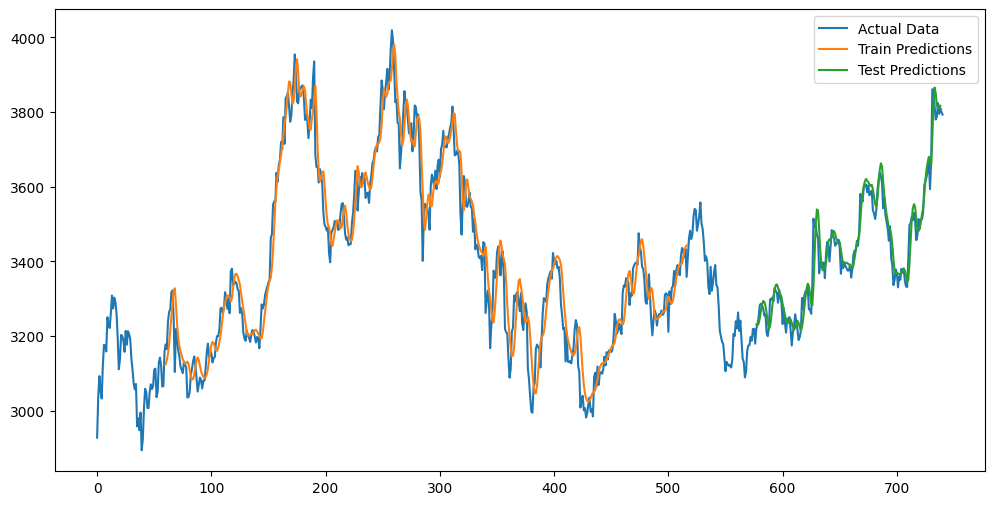

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_predict and predictions are arrays with predictions
# scaled_data is the original dataset

look_back = 60

# Initialize arrays with NaN values for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:look_back + len(train_predict), :] = train_predict

# Recalculate the correct start index for testPredictPlot
test_start_index = len(train_predict) + (look_back * 2)

# Debugging step: print shapes and indices
print(f"Length of scaled_data: {len(scaled_data)}")
print(f"Length of train_predict: {len(train_predict)}")
print(f"Length of predictions: {len(predictions)}")
print(f"Test start index: {test_start_index}")
print(f"Expected end index: {test_start_index + len(predictions)}")

# Ensure that there is enough space for predictions in testPredictPlot
if test_start_index + len(predictions) <= len(scaled_data):
    testPredictPlot = np.empty_like(scaled_data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[test_start_index:test_start_index + len(predictions), :] = predictions
else:
    print("Error: Predictions exceed the size of the test data slice.")

# Plot the actual data and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaled_data, label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()
